# How to implement your own network
##torch.nn.module
Base class for all neural network modules.

Your models should also subclass this class.

When defining a subclass of nn.Module, you should rewrite the \_\_init\_\_ function to initialize what other pre-defined modules and functions that you need in this module, and how you would like to initialize them. Then you should rewrite the forward function to define how we use the input and the defined module and functions to calculate the output.

Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

Your module should contain other modules in PyTorch(for example, nn.Conv2d), and functions that are pre-defined(like F.relu and other activation function).
The autograd context of PyTorch will track your computation and automatically save the activation needed for backward propagation and compute the gradients when you call loss.backward().
But sometimes you will also need to define some functions that are not defined in torch.nn.functional or sometimes they are not differentiable. That is when you need to use the other way of defining your network: torch.autograd.function.

Different from torch.mm.module, torch.autograd.function does not contain an init function. Instead, you need to rewrite the forward and backward function for it. Also, as autograd is out of reach in this case, we will need to handle the activation ourselves. Fortunately, we have ctx here to help us. Save the intermediaten results in ctx and we can easily take them out during backward propagation. To be mentioned, the number of inputs for forward should be the same as the output of backward. Vice versa.

In [34]:
from torch.autograd import Function
# Inherit from Function
class LinearFunction(Function):

    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output
# This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None

        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0)
        return grad_input, grad_weight, grad_bias



But in most cases, the pre-defined functions of PyTorch are enough for us. So only use torch.autograd.Function when you need to manipulate the grads or when you can not easily use autograd due to cases like complicated communication in distributed training.

##Now we can look at a basic case of MLP.

In [21]:
import torch
import torchvision
from torch.utils.data import DataLoader


In [2]:
n_epochs = 2
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

##loading the data

In [4]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

##Take a look at the examples

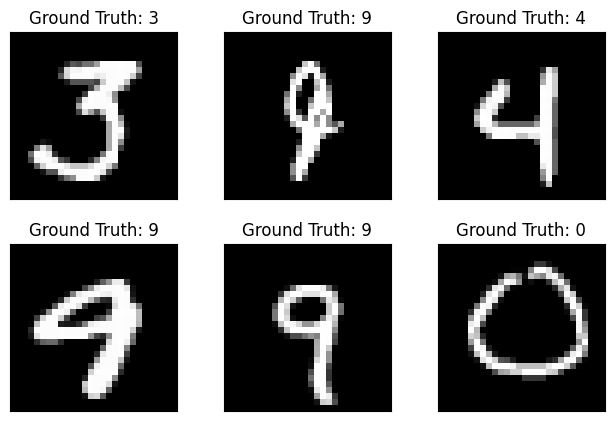

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

##Using torch.nn.Module to define our network

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Move the network to GPU and define the optimizer.

In [17]:
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [18]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


##The training loop

In [19]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.cuda()
    target = target.cuda()
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


Test function and checking the result.

<ipython-input-7-358f421c3a3b>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3056, Accuracy: 827/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335227
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.312729
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.296420
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.249634
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.285140
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.224921
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.244668
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.188633
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.164671
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.117030
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.106354
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.926432
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.980910
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.841516
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.801621
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.606411
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.639741
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.557400
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.372159
Train Epoch: 1 [12160/6

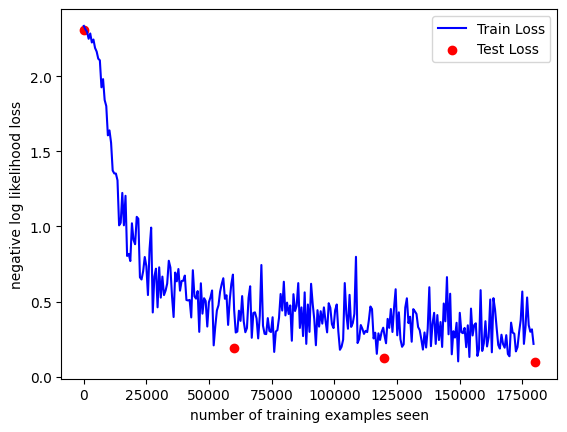

In [20]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.cuda()
      target = target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()


Credits to https://zhuanlan.zhihu.com/p/137571225 and https://zhuanlan.zhihu.com/p/344802526
